In [52]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
import csv
data = []
with open("cleaned\FL.csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    headers = next(csv_reader)
    for i in csv_reader:
        data.append(int(i[5]))

train  = data[:-100]
test = data[-100:]

li_x = []
li_y = []
seq = 2

# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[:-100]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据
    li_x.append(train[i: i+seq])
    li_y.append(train[i+seq])

t_x = []
t_y = []
# 因为数据集较少，序列长度太长会影响结果
for i in range(len(data[-100:]) - seq):
    # 输入就是[x,x+1]天的数据，输出时x+2天的数据*
    t_x.append(test[i: i+seq])
    t_y.append(test[i+seq])

# print(li_x)
# print(li_y)

# 分训练和测试集
train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)

print(train_x.shape)

test_x = (torch.tensor(t_x).float() / 1000.).reshape(-1, seq, 1).to(device)
test_y = (torch.tensor(t_y).float() / 1000.).reshape(-1, 1).to(device)

torch.Size([608, 2, 1])


In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [56]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
loss_fun = nn.MSELoss()

In [57]:
model.train()
for epoch in range(1200):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0 and epoch > 0:
        test_loss = loss_fun(model(test_x), test_y)
        print("epoch:{}, loss:{}, test_loss: {}".format(epoch, loss, test_loss))

epoch:20, loss:50.593353271484375, test_loss: 203.33375549316406
epoch:40, loss:29.898527145385742, test_loss: 176.02381896972656
epoch:60, loss:15.358475685119629, test_loss: 145.5395965576172
epoch:80, loss:9.081055641174316, test_loss: 123.50643157958984
epoch:100, loss:6.320612907409668, test_loss: 110.9237289428711
epoch:120, loss:4.879940986633301, test_loss: 101.49616241455078
epoch:140, loss:4.163252830505371, test_loss: 95.30198669433594
epoch:160, loss:3.8025617599487305, test_loss: 90.86180114746094
epoch:180, loss:3.598078727722168, test_loss: 87.543701171875
epoch:200, loss:3.467705488204956, test_loss: 85.09989929199219
epoch:220, loss:3.378634452819824, test_loss: 83.2286148071289
epoch:240, loss:3.3132195472717285, test_loss: 81.67098999023438
epoch:260, loss:3.2649588584899902, test_loss: 80.38070678710938
epoch:280, loss:3.2280726432800293, test_loss: 79.3049087524414
epoch:300, loss:3.198338270187378, test_loss: 78.38520050048828
epoch:320, loss:3.1732723712921143, t

MSE: 13074099.616587367


C:\Users\goodr\anaconda3\envs\mll\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


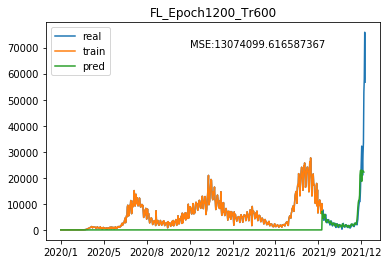

In [83]:
model.eval()
# result = li_x[0][:seq-1] + list((model(train_x).data.reshape(-1))*1000) + list((model(test_x).data.reshape(-1))*1000)
result = [0] + list((model(train_x).data.reshape(-1))*00) + list((model(test_x).data.reshape(-1))*1000)

#展示结果
plt.plot(data,label="real")
# 原来的走势

plt.plot(train,label="train")

plt.plot(result,label="pred")
plt.xticks(
    [0,100,200,300,400,500,600,700],
    ['2020/1','2020/5', '2020/8', '2020/12', '2021/2', '20211/6', '2021/9', '2021/12']
)
# 模型预测的走势
plt.legend(loc='best')
#Accuracy
from sklearn.metrics import mean_squared_error
temp0 = result[600:705]
temp1 = data[600:705]
MSE = mean_squared_error(temp0, temp1)
print("MSE:", MSE)
plt.text(300,70000,f"MSE:{MSE}")
#
plt.title(f'FL_Epoch1200_Tr600')
plt.savefig('plot/FL_Epoch1200_Tr600.jpg')
plt.show()


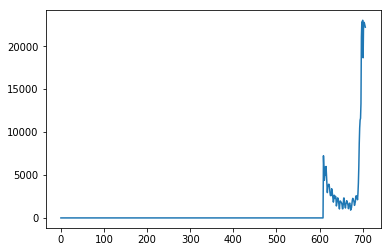

In [60]:
plt.plot(result)